<h1 style="color:darkred">Design notes</h1>
    
<li> <span style="color:darkred">Red text are design notes / comments / otherwise not intended for final version</span>
<li>Normal text is notional final version text
<li> <b><span style="color:darkred">Before running the notebook, need to run `poetry run  jupyter labextension enable widgetsnbextension` to enable the widgets</b>
</ul>




# Introduction

## Overview

This notebook is part of the NRTK demonstration suite, allowing you to both interactively apply the perturbation to a test image as well as sweep a range of perturbations over the image, testing the results against a baseline deep learning algorithm.

## Layout

This notebook demonstrates how a particular condition (in this case, <b><i>extreme illumination conditions</i></b>), can affect an object recognition model. The overall structure is:

- **Notebook initialization:** The supporting python code is loaded. Depending on if this is the first time you've run this notebook, this may take some time.
- **Image selection:** The test image is loaded. You may use either our default image from the VisDrone dataset or give your own. <span style="color:darkred">Currently only supports loading test image.</span>
- **Interactive perturbation demonstration:** Here you can interactively apply the perturbation to the test image, exploring how it visually changes as you adjust the key perturbation parameters.
- **Impact analysis:** Here you can select a range of perturbations to apply to the test image; these are then run through YOLO object detection and evaluated against an unperturbed baseline.

<span style="color:darkred">Is YOLO  / object detection appropriate? If not, is it cumbersome to support other models / tasks? TBD: pin down the precise metrics</span>

# Notebook initialization

The next few cells import the python libraries; this might take a while. <span style="color:darkred">Should we separate the NRTK-only imports from the notebook support? What are the implications to the user's environment of pip installing / uninstalling in the notebook? </span>

Note: We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that the first cell is **not** executed so that any related warnings are shown. 

In [1]:
# warning suppression
import warnings
warnings.filterwarnings('ignore')

In [24]:
# package installation
import sys

print("Beginning package installation...")
!{sys.executable} -m pip install -qU pip
print("Installing nrtk...")
!{sys.executable} -m pip install -q nrtk
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Installing ipywidgets...")
!{sys.executable} -m pip install -q ipywidgets
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless

%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations
from matplotlib import pyplot as plt  # type: ignore
from matplotlib.axes import Axes  # type: ignore

import numpy as np
import os
import urllib.request
from PIL import Image
import ipywidgets as widgets
from typing import TYPE_CHECKING, Any, Dict

from nrtk.impls.perturb_image.generic.PIL.enhance import (
    BrightnessPerturber,
    ColorPerturber,
    ContrastPerturber,
    SharpnessPerturber
)
print("Done!")

Beginning package installation...
Installing nrtk...
Installing matplotlib...
Installing ipywidgets...
Installing headless OpenCV...
Done!


# Selecting the test image

*text describing how to select their own test image, or use default VisDrone; only supporting default image for now*

<span style="color:darkred">Is there a risk in letting the user select their own image here, in that it might get saved with the state of the notebook?</span>

<span style="color:darkred">Guidance for image size: do we need to scale for reasonable yolo performance?</span>

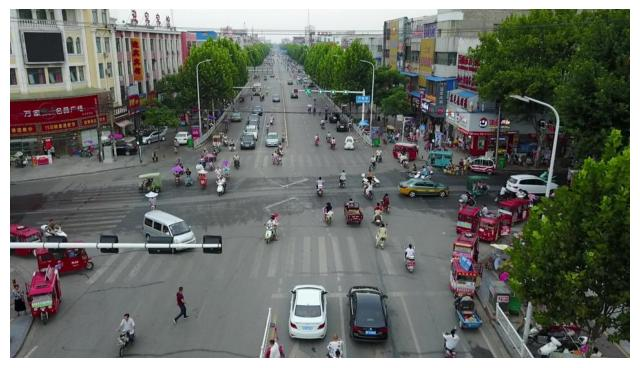

In [55]:
data_dir = './data'
os.makedirs(data_dir, exist_ok=True)

url = 'https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download'

img_path = os.path.join(data_dir, 'visdrone_img.jpg')
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)
    
img = np.asarray(Image.open(img_path))

plt.figure(figsize=(8,8))
plt.axis('off')
_ = plt.imshow(img)

# Interactive perturbation

When you run the cell below, a slider will control the brightness parameter to the BrightnessPerturber. As you move the slider, you can see how the perturbation affects the test image.

In [56]:
from ipywidgets import HBox, interactive, fixed

def apply_perturbation(brightness, img_input):
    bp = BrightnessPerturber(factor=brightness,)
    img_out = bp(img_input)
    fig, axs = plt.subplots(figsize=(8, 8))
    if TYPE_CHECKING:
        assert(isinstance(axs, Axes))
    axs.set_title(f'Brightness: {brightness}')
    axs.imshow(img_out)
    axs.axis("off")

interactive_plot = interactive(apply_perturbation, brightness=(0, 2, 0.01), img_input=fixed(img))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='brightness', max=2.0, step=0.01), Output()), _dom_cl…

# Impact analysis

This section of the notebook will sweep out the brightness parameter between low and high marks you select, creating a perturbed image at each value and running YOLOv8 object detection on it. The results will be compared against the baseline results from an unperturbed image.

<span style="color:darkred">todo: actual metrics </span>

## Analysis parameters

Execute the cell below to select the following analysis parameters:
- **Brightness low value**: the low (darker) end of the brightness perturbation range
- **Brightness high value**: the high (brighter) end of the brightness perturbation range
- **Step count**: the number of perturbed images to generate; more images yield a higher-resolution analysis but will take longer to run.

<span style="color:darkred">todo: guidance on which cells below need to be re-run if these change (i.e. can probably skip the baseline computation)</span>

<span style="color:darkred">The notebook has some hyperparameters, i.e. the endpoints of the sliders...</span>

In [54]:
def visualize_perturbation_limits(b_low, b_high, n_steps, img_input):
    bp_low = BrightnessPerturber(factor=b_low)
    bp_high = BrightnessPerturber(factor=b_high)
    img_low = bp_low(img_input)
    img_high = bp_high(img_input)
    fig, (ax_low, ax_high) = plt.subplots(1,2,figsize=(8, 8))
    ax_low.set_title(f'Low: {b_low}')
    ax_high.set_title(f'High: {b_high}')
    ax_low.imshow(img_low)
    ax_high.imshow(img_high)
    ax_low.axis("off")
    ax_high.axis("off")

analysis_parameters = interactive(visualize_perturbation_limits, b_low=(0, 2, 0.01), b_high=(0,2,0.01), n_steps=(2,20), img_input=fixed(img))
analysis_parameters

interactive(children=(FloatSlider(value=1.0, description='b_low', max=2.0, step=0.01), FloatSlider(value=1.0, …

# Baseline detections

Once you've set the analysis parameters, execute the cell below to import the YOLO framework and compute baseline detections on the test image. <span style="color:darkred">Probably need to adjust e.g. where the model file is being stored so it doesn't show up as tracked by git</span>

In [53]:
print('Installing yolo...')
!{sys.executable} -m pip install -q ultralytics
import ultralytics
ultralytics.checks()
print('Downloading model...')
model = ultralytics.YOLO('yolo11n.pt')
print('Computing baseline...')
baseline=model(img_path)
print('Done!')

Ultralytics 8.3.3 🚀 Python-3.8.10 torch-2.4.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16008MiB)
Setup complete ✅ (40 CPUs, 62.5 GB RAM, 831.4/914.7 GB disk)
Computing baseline...

image 1/1 /home/local/KHQ/roddy.collins/work/cdao/nrtk/examples/data/visdrone_img.jpg: 384x640 5 persons, 15 cars, 1 motorcycle, 2 trucks, 13.0ms
Speed: 3.7ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Done!


# Baseline detection threshold

Execute the cell below to visualize the baseline detections; move the slider to pick an appropriate detection confidence operating point. **This threshold will be used when computing the perturbed metrics.** <span style="color:darkred">(Subject to finalizing the metrics. Also could extend to show class labels, select only specific classes, etc.)</span>

In [100]:
baseline_all_conf = baseline[0].boxes.conf.cpu()
boxes = baseline[0].boxes.xywh.cpu()

def visualize_baseline_threshold(threshold):
    ann = ultralytics.utils.plotting.Annotator(img, line_width=None, font_size=None, font="Arial.ttf", pil=True)
    idx_to_show = np.argwhere(baseline_all_conf >= threshold)
    for box in boxes[idx_to_show][0]:
        (x0,y0,w,h) = box
        ann.box_label([x0-(w/2),y0-(h/2),x0+(w/2),y0+(h/2)], "",color=(255,0,0))
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(ann.result())
    ax.axis("off")
    ax.set_title('Threshold {} (n={})'.format(threshold, idx_to_show.shape[1]))

threshold_selection = interactive(visualize_baseline_threshold, threshold=(0,1.0,0.01))
threshold_selection                                  

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

# Running the analysis

You have now selected the following parameters: <span style="color:darkred">Apparently extensions are required to display inline variables in the markdown cells?!?</span>

- Brightness low value
- Brightness high value
- Number of perturbation samples between [low, high] to generate
- Detection threshold at which to compare to the baseline

Execute the cell below to generate the range of perturbed images and compute detections on each of them. The final result will be a plot of detections vs. perturbation level. <span style="color:darkred">Modify for actual metrics</span>

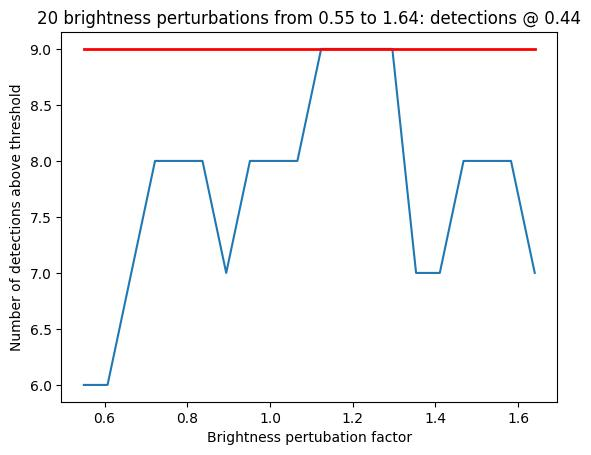

In [126]:
# compute the perturbation ranges
(b_low, b_high, n_steps) = (analysis_parameters.kwargs['b_low'], analysis_parameters.kwargs['b_high'], analysis_parameters.kwargs['n_steps'])
if (b_high < b_low):
    b_low, b_high = b_high, b_low
p_vals = np.linspace(b_low, b_high, n_steps, endpoint=True)
score_threshold = threshold_selection.kwargs['threshold']
n_at_threshold = np.argwhere(baseline_all_conf >= score_threshold).shape[1]

n_list = list()
for p_val in p_vals:
    p = BrightnessPerturber( factor=p_val )
    p_img = p(img)
    p_detect = model(p_img, verbose=False)
    p_all_conf = p_detect[0].boxes.conf.cpu()
    idx_above_threshold = np.argwhere(p_all_conf >= score_threshold)
    n_above_threshold = idx_above_threshold.shape[1]
    n_list.append(n_above_threshold)
    #print(f'Perturbation: {p_val} N >= {score_threshold}: {n_above_threshold}')

plt.title(f'{n_steps} brightness perturbations from {b_low} to {b_high}: detections @ {score_threshold}')
plt.xlabel("Brightness pertubation factor")
plt.ylabel("Number of detections above threshold")
plt.plot(p_vals, n_list)
plt.plot([p_vals[0], p_vals[-1]], [n_at_threshold, n_at_threshold], 'r-',lw=2)
plt.show()

# End of notebook